# Gridded forecast model tutorial with Italy examples

In this tutorial, we will load and test grid-based forecasts and interpret the results of the tests provided in the PyCSEP package for gridded forecasts. We will work with two time-independent grid-based forecasts submitted as part of the CSEP Italy testing experiment (see [Werner et al, 2010](https://doi.org/10.4401/ag-4840), [Taroni et al, 2018](https://doi.org/10.1785/0220180031) for some previous testing results). Our goal is to compare the performance of these two forecasts for describing observed Italian seismicity.   

This is essentially a three step process:  
    1. Read in (and plot) a gridded forecast  
    2. Set up an evaluation catalog of observed events  
    3. Run PyCSEP tests and interpret the results    


We introduce the concepts to the reader and encourage them to explore the other tests available. Full documentation of the package can be found [here](https://docs.cseptesting.org/) and any issues can be reported on the [PyCSEP Github page](https://github.com/SCECcode/pycsep).

In [1]:
# Most of the core functionality can be imported from the top-level csep package. 
# Utilities are available from the csep.utils subpackage.
import csep
from csep.core import regions, catalog_evaluations, poisson_evaluations as poisson
#from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, comcat, plots, readers

import numpy
## Cartopy required for updated plots
import cartopy

## Read in forecasts

We're going to start by setting up some experiment parameters. It is good practice to set this up early. Note, the start and end date of the forecast should be chosen based on the creation of the forecast. This is important for time-independent forecasts because they can be rescaled to any arbitrary time period.

In [2]:
## Set up experiment parameters
start_date = time_utils.strptime_to_utc_datetime('2010-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2015-01-01 00:00:00.0')


These forecasts are included with the main repository in the case of the Werner forecast and the tutorial repository for the Meletti forecast. You can learn more about the format of gridded forecasts [in the documentation](https://docs.cseptesting.org/concepts/forecasts.html). The filepath is relative to the root directory of the package, so you can specify any file location for your forecasts. You can also attach a name, which is very useful for comparisons later if you chose something sensible.

In [3]:
## Loads from the PyCSEP package
werner_forecast = csep.load_gridded_forecast(datasets.hires_ssm_italy_fname,
                                      name='Werner, et al (2010)')

In [4]:
## You may need to edit the file location here depending on your set up
meletti_forecast = csep.load_gridded_forecast("pycsep_workshop_rise21/workshop_data/forecasts/Italy_Forecasts_5yr/meletti.MPS04after.italy.5yr.2010-01-01.dat",
                                              name ="Meletti et al (2010), MPS working group")

Gridded forecasts inherit the region from the forecast, so there is no requirement to explicitly set this. We should check, however, that the forecast regions for catalogs we want to compare are the same so that they are testable with a single catalog. 

In [5]:
## Sanity check - if catalogs have the same region this will provide no output.
numpy.testing.assert_allclose(meletti_forecast.region.midpoints(), werner_forecast.region.midpoints())

To visualise this forecast, we will use `forecast.plot()` with some specifications to get a nicer looking figure. We will do this by creating a dictionary containing the plot arguments.  

These arguments are, in order:

    - Assign a title
    - Set labels to the geographic axes
    - Draw country borders
    - Set a linewidth of 0.5 to country borders
    - Select ESRI Imagery as a basemap.
    - Assign 'rainbow' as colormap. Possible values from from matplotlib.cm library
    - Defines 0.8 for an exponential transparency function (default is 0 for constant alpha, whereas 1 for linear).
    - An object cartopy.crs.Projection() is passed as Projection to the map  
 
 The complete description of plot arguments can be found in `csep.utils.plots.plot_spatial_dataset`

In [6]:
args_dict = {'title': 'Italy 10 year forecast',
             'grid_labels': True,
             'borders': True,
             'feature_lw': 0.5,
             'basemap': 'ESRI_imagery',
             'cmap': 'rainbow',
             'alpha_exp': 0.8,
             'projection': cartopy.crs.Mercator()}

The map extent can also be defined. Otherwise, the extent of the data would be used. The dictionary defined must be passed as an argument. 

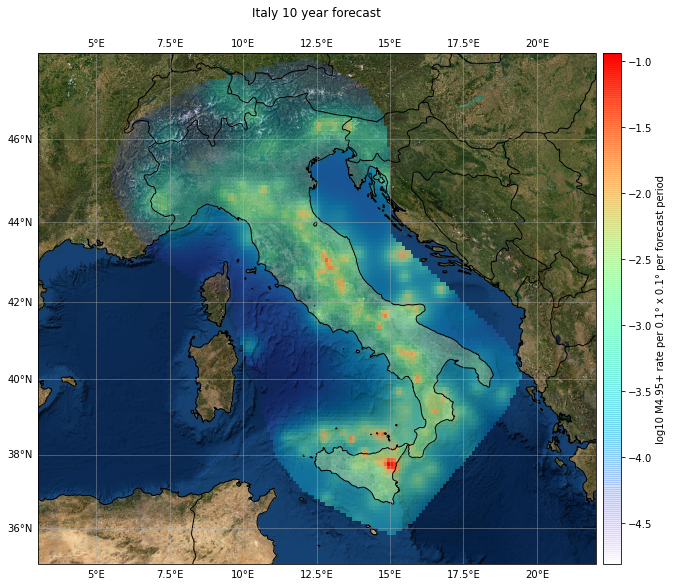

In [7]:
ax = werner_forecast.plot(extent=[3, 22, 35, 48],
                   show=True,
                   plot_args=args_dict)

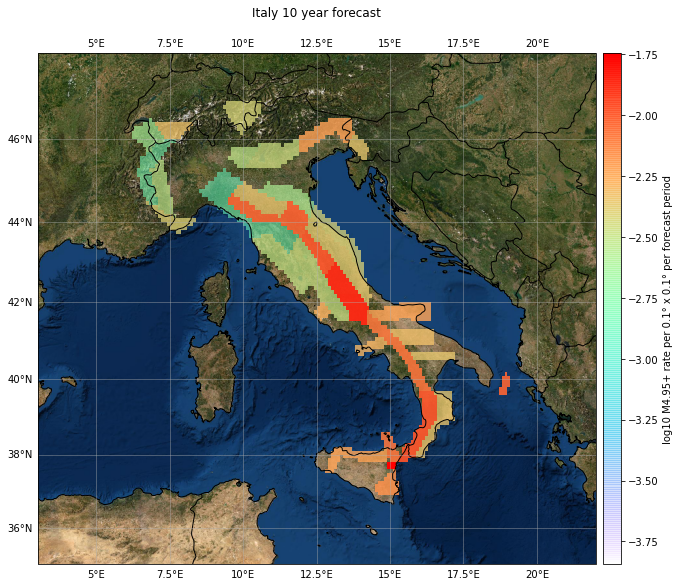

In [8]:
# Plot the second forecast
# An excercise for the reader
ax = ??

## Set up evaluation catalog

Now we need to import the observed catalog that we want to use to test the forecast - we call this the evaluation catalog.  

There are multiple ways to read in evaluation catalogs, including reading directly from ComCat for US models. There are also various readers currently included with the package, including those for JMA and the INGV HORUS catalogs. These functions are in `/csep/utils/readers.py` if you would like to see them or understand how to add your own.  

In this case we demonstrate using the European RCMT catalog.

In [9]:
## load catalog
italy_test_catalog = csep.load_catalog("pycsep_workshop_rise21/workshop_data/catalogs/europe_rcmt_2010-2015.csv", type="ingv_emrcmt")

Removed 9 badly formatted events
Removed 0 repeated events


Print the catalog to check the range of dates, locations and magnitudes of the events in the evaluation catalog, as well as the total number of events.

We can also filter the catalog to the desired time-space-magnitude range. Crucially, we must also filter the catalog to the forecast region in order to carry out any testing in the next step. This is also why we checked that the forecasts we want to compare are in the same spatial region. 

In [11]:
italy_test_catalog = italy_test_catalog.filter_spatial(werner_forecast.region)

Note that our magnitude range is not consistent with the parameters we established earlier, so we have to filter for magnitude also. This is obviously important to fairly test a forecast, and you can see why if you re-run this tutorial without this step!

In [12]:
italy_test_catalog = italy_test_catalog.filter('magnitude >= 4.95')

If you have run the above code, you should be left with a catalog of 13 events. Print the catalog with the standard python `print` command to check the range of dates, locations and magnitudes of the events in the evaluation catalog, as well as the total number of events.


        Name: None
        
        Start Date: 2010-11-03 18:13:10+00:00
        End Date: 2013-12-29 17:08:43+00:00
        
        Latitude: (39.88, 44.89)
        Longitude: (10.03, 16.01)
        
        Min Mw: 5.0
        Max Mw: 6.1
        
        Event Count: 13
        


## Run consistency tests

Now we wish to answer some questions about our forecasts and their performance. In this example, we will investigate the spatial properties of the forecast models and how well the forecasts describe the observed spatial distribution of seismicity.

The consistency tests implemented for gridded forecasts in PyCSEP are the N, S and M-test described in [Schorlemmer et al, 2007](https://doi.org/10.1785/gssrl.78.1.17) and [Zechar et al, 2010](https://doi.org/10.1785/0120090192). These are located in the `poisson_evaluations` file that we have imported as `poisson`. To carry out a test, we simply provide the forecast we wish to test and an evaluation forecast. The spatial test requires simulating from the Poisson forecast to provide uncertainty. The verbose option prints the status of the simulations to the standard output.

In [23]:
spatial_test_result_werner = poisson.spatial_test(werner_forecast, italy_test_catalog)

In [19]:
## Repeat the spatial test for our second example forecast
spatial_test_result_meletti = ???

PyCSEP provides easy ways of storing objects to a JSON format using csep.write_json(). The evaluations can be read back into the program for plotting using `csep.load_evaluation_result()`.

In [20]:
## Run this cell to write to .json file (optional)
## You can look at the contents of this file in jupyter lab to see how the data is stored
csep.write_json(spatial_test_result_meletti, 'example_spatial_test.json')

We can plot these results using the `plot_poisson_consistency_test` function from the `plots` file of `csep.utils`, where you can find more details on the plot arguments. Again, we use a dictionary to set up some plot arguments.

In [21]:
args = {'figsize': (6,5),
        'title': r'$\mathcal{S}-\mathrm{test}$',
        'title_fontsize': 18,
        'xlabel': 'Log-likelihood',
        'xticks_fontsize': 12,
        'ylabel_fontsize': 12,
        'linewidth': 1,
        'capsize': 4,
        'hbars':True,
        'tight_layout': True}

We're now going to plot the results of both forecasts for comparison. We set `one_sided_lower=True` as usual for an L-test, where the model is rejected if the observed is located within the lower tail of the simulated distribution. We can supply multiple `spatial_test_result` objects in a list (specified in the square brackets as standard in python).

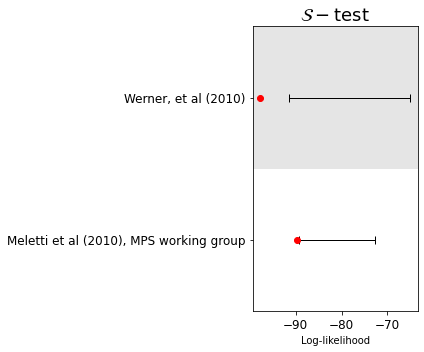

In [24]:
ax = plots.plot_poisson_consistency_test([spatial_test_result_werner, spatial_test_result_meletti], one_sided_lower=True, plot_args=args)

This tells us something about the spatial performance of these models. We can repeat this process for N or M tests using the `number_test` or `magnitude_test` from `poisson_evaluations` if we are more interested in these components specifically, or getting a fuller picture of where the forecast does well and not so well.   
Try out a `likelihood_test` or `conditional_likelihood_test` (also from `poisson_evaluations`). What does this tell you about the two forecasts?

## Compare forecast test results

Now that we have test results for two different forecasts, we want to compare their performance in terms of their information gain. We will implement this using the T-test, which [Rhoades et al, 2011](https://link.springer.com/article/10.2478/s11600-011-0013-5) describe as a better method of directly comparing likelihoods than the above consistency tests.  
The paired T-test compares a forecast to a base model, in this case we have chosen to use `meletti_forecast` as the baseline and any other models are compared to it. As the 'paired' part implies, the paired T-test always takes two forecast arguments, though we can run it for multiple different models by repeating the call, updating the first forecast argument and holding the second one fixed.

In [25]:
paired_test1 = poisson.paired_t_test(werner_forecast, meletti_forecast, italy_test_catalog)

The `plot_comparison_test` function is used here, which works similarly to the other `plots` functions. Again, we can set up our plot arguments with a dictionary. 

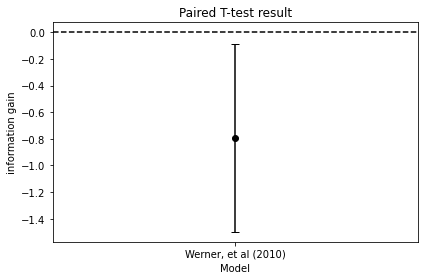

In [27]:
comp_args = {'title': 'Paired T-test result',
             'ylabel': 'information gain',
             'xlabel': 'Model'}

ax = plots.plot_comparison_test([paired_test1],
                                        plot_args= comp_args)

How should this result be interpreted? Are there other tests that might be useful here? What are your overall conclusions on the performance of these two forecasts?  


If you are happy with all of this so far, you can try:  
    - Changing the time period for the evaluation    
    - Filtering the evalutaion catalog by a different time period or magnitude    
    - Using PyCSEP gridded-forecast tests on your own forecast models

### References  

Rhoades, D. A., D. Schorlemmer, M. C. Gerstenberger, A. Christophersen, J. D. Zechar, and M. Imoto (2011). Efficient testing of earthquake forecasting models, Acta Geophys 59 728-747.    
Schorlemmer, D., M. Gerstenberger, S. Wiemer, D. D. Jackson, and D. A. Rhoades (2007). Earthquake likelihood model testing, Seismological Research Letters 78 17-29.  
Taroni, M., W. Marzocchi, D. Schorlemmer, M. J. Werner, S. Wiemer, J. D. Zechar, L. Heiniger, F. Euchner (2018). Prospective CSEP Evaluation of 1‐Day, 3‐Month, and 5‐Yr Earthquake Forecasts for Italy, Seismological Research Letters (2018) 89 (4): 1251–1261  
Werner, M. J., J. D. Zechar, W. Marzocchi, S., CSEP-Italy Working Group (2010). Retrospective evaluation of the five-year and ten-year CSEP-Italy earthquake forecasts, Annals of Geophysics, 53, 3.  
Zechar, J. D., M. C. Gerstenberger, and D. A. Rhoades (2010). Likelihood-Based Tests for Evaluating Space-Rate-Magnitude Earthquake Forecasts, Bulletin of the Seismological Society of America 100 1184-1195.